# Training of Model
 - Deep Q Reinforcement Learning
 - Model based on following Github: [Link](https://github.com/pskrunner14/trading-bot)
 - Modifications: Second input feature (1 Target, 1 additional Feature)
 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
#import seaborn as sns
import datetime
import pandas_datareader.data as web


import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

# Altair:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


RendererRegistry.enable('notebook')

## Set relevant parameters
 - Window-Size: cutout of stock data that agent gets as state for his decision making
 - ep_count: # of epochs
 - Model Name (model saved automatically after 10 epochs)
 - Pretrained: Load Pretrained Model or create new one

In [2]:
window_size = 12
batch_size = 20 #16
ep_count = 150 # 3-5 for debugging, otherwise 20-100
model_name = 'model_w12v4'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame
__Training on different Stocks:__
 - Growth: Adobe (ADBE), Apple (AAPL), Amazon (AMZN), Cerner (CERN), Salesforce(CRM), Expedia(EXPE)
 - Cyclical: Royal Caribbean (RCL), Wynn Resorts(WYNN)
 - Slow and low dividend: Costco (COST), ADP(ADP), Lowe's(LOW)
 - Turnaround: ArcBest Trucking(ARCB), Abercombie&Fitch(ANF), Meritage Homes(MTH)
 - Second Feature: Gold


Symbols,AAPL,ADBE,ADP,AMZN,ANF,ARCB,CERN,CRM,EXPE,LOW,MTH,RCL,WYNN
Date,,,,,,,,,,,,,
2012-01-03,51.269413,28.570000,39.757862,179.029999,37.513138,17.979559,31.115179,25.299999,27.385767,22.221781,23.780001,22.028625,86.954262
2012-01-04,51.544937,28.280001,39.714073,177.509995,36.262455,18.276583,30.702301,24.370001,26.804073,23.049004,23.709999,22.215746,85.458839
2012-01-05,52.117188,28.480000,40.006092,177.610001,35.211254,18.452946,31.055487,24.692499,26.564005,22.961931,24.299999,22.113682,84.566162
2012-01-06,52.662014,28.719999,40.064480,182.610001,34.459309,18.861364,31.572830,25.264999,27.007204,22.935804,24.389999,21.688419,81.590660
2012-01-09,52.578468,28.530001,39.911171,178.559998,35.011761,18.870644,31.413649,25.187500,26.434744,22.726822,24.450001,21.756460,81.361763


<Figure size 432x288 with 0 Axes>

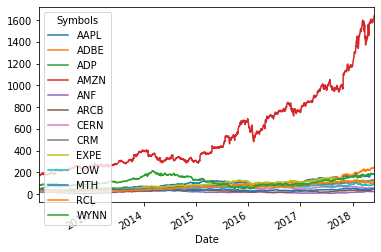

In [5]:
# Loading Train Data
# Setting Start and Enddate for Validation

start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 6, 1)
start_val = end_train
end_val = datetime.datetime.now()

TStocks = ['ADBE', 'AAPL', 'AMZN', 'CERN', 'CRM','EXPE','RCL', 'WYNN', 'ADP', 'LOW', 'ARCB', 'ANF', 'MTH']


# Load Train Data

# Load Target Feature
df_train = web.DataReader(TStocks,'yahoo',
                               start=start_train, end=end_train)['Adj Close']

# Load Second Feature (Gold as a sign for crysis)
df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader(TStocks,'yahoo',
                               start=start_val, #start_train
                               end=end_val)['Adj Close'] #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val


# Convert df2_test to list
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])

plt.figure();
df_train.plot();
df_train.head()

## Training of Model
 - Create new model for every stock
 - Training 1 model on all stocks led to poor results

In [ ]:
#Training
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)



reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting



for column in df_train:
    model_name = 'model_name' + "_" + column
    print(model_name)

    #Init agent, if second feature: Window size for state doubled
    
    if df2_train is not None:
        agent = Agent(window_size*2, pretrained=False, model_name=model_name)
    else:
        agent = Agent(window_size, pretrained=False, model_name=model_name)
    
    
    #create list as input for model
    df_train_list = list(df_train[column])
    df_val_list = list(df_val[column])

    for i in range(1, ep_count + 1): 
        initial_offset = df_train_list[1] - df_train_list[0]
             
        train_result = train_model(agent, i, df_train_list, df2_train_list, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
        val_result, _ = evaluate_model(agent, df_val_list, df2_val_list, window_size, debug)
        show_train_result(train_result, val_result, initial_offset)
      
        reslist_t.append(train_result[2]) # append reward of training
        reslist_v.append(val_result)
        
# Plotting Training History  
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()

I1008 22:20:41.298027 17656 train.py:156] switching to TensorFlow for CPU
2019-10-08 22:20:41 PC-Stefan root[16776] DEBUG switching to TensorFlow for CPU


model_name_AAPL


W1008 22:20:41.337325 17656 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2019-10-08 22:20:41 PC-Stefan tensorflow[16776] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 22:20:41.352965 17656 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

2019-10-08 22:20:41 PC-Stefan tensorflow[16776] WARNING From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 22:20:41.352

## Visualization of actions taken by Trading Bot

In [6]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Plotting the evaluation actions

## Testing the Model
__Select correct model for Testing! (test model not linked to trained model)__

### Load different types of stocks in model:

 
### Load generated data
  - Sin function
  - Random Data
 
 

I1007 01:51:51.963366 15072 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-07 01:51:51 PC-Stefan urllib3.connectionpool[3960] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I1007 01:51:52.447771 15072 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1570499999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-07 01:51:52 PC-Stefan urllib3.connectionpool[3960] DEBUG https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1570499999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I1007 01:51:52.916564 15072 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&period2=1570499999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-07 01:51:52 PC-Stefan urllib3.connectionpool[3960] DEBUG https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&period2=

<Figure size 432x288 with 0 Axes>

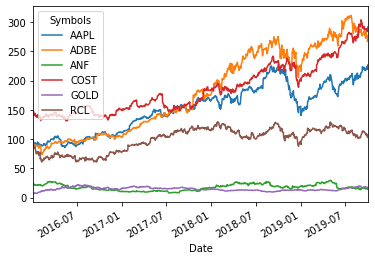

In [6]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']

#Add random column for testing
#df_test['random']=np.random.randint(1,100,df_test.shape[0])
#df_test['sine']=50+50*np.sin(np.linspace(1,100,df_test.shape[0]))

# define second data input
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])


plt.figure();
df_test.plot();


In [ ]:
# Loop over all Models and test them
# If window size does not fit, pass and try next model

result = []

for models in os.listdir("models/"):

    
    #model_name = 'model_w15v2_40'
    model_name = models
    
    # Init Model
    window_size = 10

    try: 
        # Initialize Agent
        if df2_test_list is not None:
            agent = Agent(window_size*2, pretrained=True, model_name=model_name)
        else:
            agent = Agent(window_size, pretrained=True, model_name=model_name)

        sum = 0
        # Loop over stocks
        for column in df_test:
            #print(column)
            #rename feature column name
            df_test_list = list(df_test[column])
            dft = df_test.rename(columns={column: 'actual'})
            initial_offset = df_test_list[1] - df_test_list[0]
            val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
            show_eval_result(model_name, val_result, initial_offset);
            chart = visualize(dft, history)
            sum = sum+val_result
            #print("Earnings of Model: ", model_name, " is: ", val_result)
            #chart.display()
        print("Sum of all earnings: ", model_name, " is: ", sum)
        tx1 = model_name + " = " + str(sum)
        result.append(tx1)
    except: 
        print(models, "wrong windowsize")
        pass
print(result)

I1007 07:16:57.044422 15072 evaluate.py:111] model_Fav1: +$1140.10

2019-10-07 07:16:57 PC-Stefan root[3960] INFO model_Fav1: +$1140.10

I1007 07:16:59.669598 15072 evaluate.py:111] model_Fav1: +$1997.28

2019-10-07 07:16:59 PC-Stefan root[3960] INFO model_Fav1: +$1997.28

I1007 07:17:02.216644 15072 evaluate.py:111] model_Fav1: -$67.77

2019-10-07 07:17:02 PC-Stefan root[3960] INFO model_Fav1: -$67.77

I1007 07:17:04.779315 15072 evaluate.py:111] model_Fav1: +$1475.86

2019-10-07 07:17:04 PC-Stefan root[3960] INFO model_Fav1: +$1475.86

I1007 07:17:07.326361 15072 evaluate.py:111] model_Fav1: +$94.93

2019-10-07 07:17:07 PC-Stefan root[3960] INFO model_Fav1: +$94.93

I1007 07:17:09.842154 15072 evaluate.py:111] model_Fav1: +$426.85

2019-10-07 07:17:09 PC-Stefan root[3960] INFO model_Fav1: +$426.85



Sum of all earnings:  model_Fav1  is:  5067.253144264221
model_GOOGL_10 wrong windowsize
model_GOOGL_20 wrong windowsize
model_GOOGL_30 wrong windowsize
model_GOOGL_40 wrong windowsize
model_GOOGL_50 wrong windowsize


I1007 07:19:11.994755 15072 evaluate.py:111] model_Stefan2_10: +$16.80

2019-10-07 07:19:11 PC-Stefan root[3960] INFO model_Stefan2_10: +$16.80

I1007 07:19:14.869946 15072 evaluate.py:111] model_Stefan2_10: -$0.49

2019-10-07 07:19:14 PC-Stefan root[3960] INFO model_Stefan2_10: -$0.49

I1007 07:19:17.729514 15072 evaluate.py:111] model_Stefan2_10: +$2.07

2019-10-07 07:19:17 PC-Stefan root[3960] INFO model_Stefan2_10: +$2.07

I1007 07:19:20.526577 15072 evaluate.py:111] model_Stefan2_10: +$19.45

2019-10-07 07:19:20 PC-Stefan root[3960] INFO model_Stefan2_10: +$19.45

I1007 07:19:23.386143 15072 evaluate.py:111] model_Stefan2_10: +$0.45

2019-10-07 07:19:23 PC-Stefan root[3960] INFO model_Stefan2_10: +$0.45

I1007 07:19:26.183205 15072 evaluate.py:111] model_Stefan2_10: +$2.78

2019-10-07 07:19:26 PC-Stefan root[3960] INFO model_Stefan2_10: +$2.78



Sum of all earnings:  model_Stefan2_10  is:  41.06446933746338


I1007 07:19:52.309955 15072 evaluate.py:111] model_Stefan2_20: +$125.46

2019-10-07 07:19:52 PC-Stefan root[3960] INFO model_Stefan2_20: +$125.46

I1007 07:19:55.013271 15072 evaluate.py:111] model_Stefan2_20: +$23.30

2019-10-07 07:19:55 PC-Stefan root[3960] INFO model_Stefan2_20: +$23.30

I1007 07:19:57.716585 15072 evaluate.py:111] model_Stefan2_20: -$0.85

2019-10-07 07:19:57 PC-Stefan root[3960] INFO model_Stefan2_20: -$0.85

I1007 07:20:00.513628 15072 evaluate.py:111] model_Stefan2_20: +$26.12

2019-10-07 07:20:00 PC-Stefan root[3960] INFO model_Stefan2_20: +$26.12

I1007 07:20:03.279707 15072 evaluate.py:111] model_Stefan2_20: -$0.19

2019-10-07 07:20:03 PC-Stefan root[3960] INFO model_Stefan2_20: -$0.19

I1007 07:20:06.076502 15072 evaluate.py:111] model_Stefan2_20: -$0.14

2019-10-07 07:20:06 PC-Stefan root[3960] INFO model_Stefan2_20: -$0.14



Sum of all earnings:  model_Stefan2_20  is:  173.69784832000732


I1007 07:20:32.073607 15072 evaluate.py:111] model_Stefan2_30: +$189.76

2019-10-07 07:20:32 PC-Stefan root[3960] INFO model_Stefan2_30: +$189.76

I1007 07:20:34.839418 15072 evaluate.py:111] model_Stefan2_30: +$193.38

2019-10-07 07:20:34 PC-Stefan root[3960] INFO model_Stefan2_30: +$193.38

I1007 07:20:37.525180 15072 evaluate.py:111] model_Stefan2_30: +$0.27

2019-10-07 07:20:37 PC-Stefan root[3960] INFO model_Stefan2_30: +$0.27

I1007 07:20:40.259745 15072 evaluate.py:111] model_Stefan2_30: +$21.30

2019-10-07 07:20:40 PC-Stefan root[3960] INFO model_Stefan2_30: +$21.30

I1007 07:20:42.947404 15072 evaluate.py:109] model_Stefan2_30: USELESS

2019-10-07 07:20:42 PC-Stefan root[3960] INFO model_Stefan2_30: USELESS

I1007 07:20:45.650731 15072 evaluate.py:111] model_Stefan2_30: +$26.87

2019-10-07 07:20:45 PC-Stefan root[3960] INFO model_Stefan2_30: +$26.87



Sum of all earnings:  model_Stefan2_30  is:  431.57746505737305


I1007 07:21:11.808775 15072 evaluate.py:111] model_Stefan2_40: +$144.71

2019-10-07 07:21:11 PC-Stefan root[3960] INFO model_Stefan2_40: +$144.71

I1007 07:21:14.527643 15072 evaluate.py:111] model_Stefan2_40: +$36.98

2019-10-07 07:21:14 PC-Stefan root[3960] INFO model_Stefan2_40: +$36.98

I1007 07:21:17.543646 15072 evaluate.py:111] model_Stefan2_40: +$1.09

2019-10-07 07:21:17 PC-Stefan root[3960] INFO model_Stefan2_40: +$1.09

I1007 07:21:20.199918 15072 evaluate.py:111] model_Stefan2_40: +$68.30

2019-10-07 07:21:20 PC-Stefan root[3960] INFO model_Stefan2_40: +$68.30

I1007 07:21:22.965828 15072 evaluate.py:109] model_Stefan2_40: USELESS

2019-10-07 07:21:22 PC-Stefan root[3960] INFO model_Stefan2_40: USELESS

I1007 07:21:25.669032 15072 evaluate.py:111] model_Stefan2_40: +$2.22

2019-10-07 07:21:25 PC-Stefan root[3960] INFO model_Stefan2_40: +$2.22



Sum of all earnings:  model_Stefan2_40  is:  253.30291748046875


I1007 07:21:52.151449 15072 evaluate.py:111] model_Stefan2_50: +$1299.96

2019-10-07 07:21:52 PC-Stefan root[3960] INFO model_Stefan2_50: +$1299.96

I1007 07:21:54.964128 15072 evaluate.py:111] model_Stefan2_50: +$1452.50

2019-10-07 07:21:54 PC-Stefan root[3960] INFO model_Stefan2_50: +$1452.50

I1007 07:21:57.807949 15072 evaluate.py:111] model_Stefan2_50: -$56.69

2019-10-07 07:21:57 PC-Stefan root[3960] INFO model_Stefan2_50: -$56.69

I1007 07:22:00.651901 15072 evaluate.py:111] model_Stefan2_50: +$1376.38

2019-10-07 07:22:00 PC-Stefan root[3960] INFO model_Stefan2_50: +$1376.38

I1007 07:22:03.480221 15072 evaluate.py:111] model_Stefan2_50: +$5.76

2019-10-07 07:22:03 PC-Stefan root[3960] INFO model_Stefan2_50: +$5.76

I1007 07:22:06.355396 15072 evaluate.py:111] model_Stefan2_50: +$423.19

2019-10-07 07:22:06 PC-Stefan root[3960] INFO model_Stefan2_50: +$423.19



Sum of all earnings:  model_Stefan2_50  is:  4501.0882658958435


I1007 07:22:32.914077 15072 evaluate.py:111] model_Stefan_10: +$1140.10

2019-10-07 07:22:32 PC-Stefan root[3960] INFO model_Stefan_10: +$1140.10

I1007 07:22:35.554880 15072 evaluate.py:111] model_Stefan_10: +$1997.28

2019-10-07 07:22:35 PC-Stefan root[3960] INFO model_Stefan_10: +$1997.28

I1007 07:22:38.226933 15072 evaluate.py:111] model_Stefan_10: -$67.77

2019-10-07 07:22:38 PC-Stefan root[3960] INFO model_Stefan_10: -$67.77

I1007 07:22:40.898988 15072 evaluate.py:111] model_Stefan_10: +$1475.86

2019-10-07 07:22:40 PC-Stefan root[3960] INFO model_Stefan_10: +$1475.86

I1007 07:22:43.617919 15072 evaluate.py:111] model_Stefan_10: +$94.93

2019-10-07 07:22:43 PC-Stefan root[3960] INFO model_Stefan_10: +$94.93

I1007 07:22:46.289973 15072 evaluate.py:111] model_Stefan_10: +$426.85

2019-10-07 07:22:46 PC-Stefan root[3960] INFO model_Stefan_10: +$426.85



Sum of all earnings:  model_Stefan_10  is:  5067.253144264221


I1007 07:23:13.042067 15072 evaluate.py:111] model_Stefan_20: +$45.40

2019-10-07 07:23:13 PC-Stefan root[3960] INFO model_Stefan_20: +$45.40

I1007 07:23:15.760759 15072 evaluate.py:111] model_Stefan_20: +$85.08

2019-10-07 07:23:15 PC-Stefan root[3960] INFO model_Stefan_20: +$85.08

I1007 07:23:18.510945 15072 evaluate.py:111] model_Stefan_20: +$2.45

2019-10-07 07:23:18 PC-Stefan root[3960] INFO model_Stefan_20: +$2.45

I1007 07:23:21.339360 15072 evaluate.py:111] model_Stefan_20: +$25.86

2019-10-07 07:23:21 PC-Stefan root[3960] INFO model_Stefan_20: +$25.86

I1007 07:23:24.339459 15072 evaluate.py:109] model_Stefan_20: USELESS

2019-10-07 07:23:24 PC-Stefan root[3960] INFO model_Stefan_20: USELESS

I1007 07:23:27.152149 15072 evaluate.py:111] model_Stefan_20: +$64.56

2019-10-07 07:23:27 PC-Stefan root[3960] INFO model_Stefan_20: +$64.56



Sum of all earnings:  model_Stefan_20  is:  223.35221576690674


I1007 07:23:54.247693 15072 evaluate.py:111] model_w10v3_AAPL_10: +$93.64

2019-10-07 07:23:54 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$93.64

I1007 07:23:57.091634 15072 evaluate.py:111] model_w10v3_AAPL_10: +$90.88

2019-10-07 07:23:57 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$90.88

I1007 07:23:59.810565 15072 evaluate.py:111] model_w10v3_AAPL_10: +$0.31

2019-10-07 07:23:59 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$0.31

I1007 07:24:02.529498 15072 evaluate.py:111] model_w10v3_AAPL_10: +$59.22

2019-10-07 07:24:02 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$59.22

I1007 07:24:05.248430 15072 evaluate.py:111] model_w10v3_AAPL_10: +$1.52

2019-10-07 07:24:05 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$1.52

I1007 07:24:07.936109 15072 evaluate.py:111] model_w10v3_AAPL_10: +$35.42

2019-10-07 07:24:07 PC-Stefan root[3960] INFO model_w10v3_AAPL_10: +$35.42



Sum of all earnings:  model_w10v3_AAPL_10  is:  281.00118350982666


I1007 07:24:35.104963 15072 evaluate.py:111] model_w10v3_AAPL_100: +$366.63

2019-10-07 07:24:35 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: +$366.63

I1007 07:24:38.120775 15072 evaluate.py:111] model_w10v3_AAPL_100: +$333.46

2019-10-07 07:24:38 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: +$333.46

I1007 07:24:41.027230 15072 evaluate.py:111] model_w10v3_AAPL_100: -$6.20

2019-10-07 07:24:41 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: -$6.20

I1007 07:24:43.933666 15072 evaluate.py:111] model_w10v3_AAPL_100: +$311.03

2019-10-07 07:24:43 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: +$311.03

I1007 07:24:46.902613 15072 evaluate.py:111] model_w10v3_AAPL_100: +$8.00

2019-10-07 07:24:46 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: +$8.00

I1007 07:24:49.824683 15072 evaluate.py:111] model_w10v3_AAPL_100: +$121.64

2019-10-07 07:24:49 PC-Stefan root[3960] INFO model_w10v3_AAPL_100: +$121.64



Sum of all earnings:  model_w10v3_AAPL_100  is:  1134.560429096222


I1007 07:25:17.248399 15072 evaluate.py:111] model_w10v3_AAPL_20: +$161.48

2019-10-07 07:25:17 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: +$161.48

I1007 07:25:20.139355 15072 evaluate.py:111] model_w10v3_AAPL_20: +$122.63

2019-10-07 07:25:20 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: +$122.63

I1007 07:25:23.061398 15072 evaluate.py:111] model_w10v3_AAPL_20: -$1.88

2019-10-07 07:25:23 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: -$1.88

I1007 07:25:25.920969 15072 evaluate.py:111] model_w10v3_AAPL_20: +$28.27

2019-10-07 07:25:25 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: +$28.27

I1007 07:25:28.717914 15072 evaluate.py:111] model_w10v3_AAPL_20: -$0.23

2019-10-07 07:25:28 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: -$0.23

I1007 07:25:31.733738 15072 evaluate.py:111] model_w10v3_AAPL_20: +$60.93

2019-10-07 07:25:31 PC-Stefan root[3960] INFO model_w10v3_AAPL_20: +$60.93



Sum of all earnings:  model_w10v3_AAPL_20  is:  371.2116594314575


I1007 07:26:00.819404 15072 evaluate.py:111] model_w10v3_AAPL_30: +$116.92

2019-10-07 07:26:00 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: +$116.92

I1007 07:26:03.835337 15072 evaluate.py:111] model_w10v3_AAPL_30: +$228.61

2019-10-07 07:26:03 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: +$228.61

I1007 07:26:06.866688 15072 evaluate.py:111] model_w10v3_AAPL_30: -$10.13

2019-10-07 07:26:06 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: -$10.13

I1007 07:26:09.835639 15072 evaluate.py:111] model_w10v3_AAPL_30: +$118.82

2019-10-07 07:26:09 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: +$118.82

I1007 07:26:12.867072 15072 evaluate.py:111] model_w10v3_AAPL_30: -$1.42

2019-10-07 07:26:12 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: -$1.42

I1007 07:26:15.882899 15072 evaluate.py:111] model_w10v3_AAPL_30: +$63.65

2019-10-07 07:26:15 PC-Stefan root[3960] INFO model_w10v3_AAPL_30: +$63.65



Sum of all earnings:  model_w10v3_AAPL_30  is:  516.4547519683838


I1007 07:26:43.537638 15072 evaluate.py:111] model_w10v3_AAPL_40: +$221.74

2019-10-07 07:26:43 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: +$221.74

I1007 07:26:46.397079 15072 evaluate.py:111] model_w10v3_AAPL_40: +$187.76

2019-10-07 07:26:46 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: +$187.76

I1007 07:26:49.412908 15072 evaluate.py:111] model_w10v3_AAPL_40: -$16.56

2019-10-07 07:26:49 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: -$16.56

I1007 07:26:52.303742 15072 evaluate.py:111] model_w10v3_AAPL_40: +$149.68

2019-10-07 07:26:52 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: +$149.68

I1007 07:26:55.116878 15072 evaluate.py:111] model_w10v3_AAPL_40: -$4.55

2019-10-07 07:26:55 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: -$4.55

I1007 07:26:57.960752 15072 evaluate.py:111] model_w10v3_AAPL_40: +$84.15

2019-10-07 07:26:57 PC-Stefan root[3960] INFO model_w10v3_AAPL_40: +$84.15



Sum of all earnings:  model_w10v3_AAPL_40  is:  622.2169437408447


I1007 07:27:25.635580 15072 evaluate.py:111] model_w10v3_AAPL_50: +$556.80

2019-10-07 07:27:25 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: +$556.80

I1007 07:27:28.495045 15072 evaluate.py:111] model_w10v3_AAPL_50: +$306.07

2019-10-07 07:27:28 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: +$306.07

I1007 07:27:31.370237 15072 evaluate.py:111] model_w10v3_AAPL_50: -$9.72

2019-10-07 07:27:31 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: -$9.72

I1007 07:27:34.245411 15072 evaluate.py:111] model_w10v3_AAPL_50: +$467.66

2019-10-07 07:27:34 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: +$467.66

I1007 07:27:37.245613 15072 evaluate.py:111] model_w10v3_AAPL_50: +$4.75

2019-10-07 07:27:37 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: +$4.75

I1007 07:27:40.230186 15072 evaluate.py:111] model_w10v3_AAPL_50: +$511.95

2019-10-07 07:27:40 PC-Stefan root[3960] INFO model_w10v3_AAPL_50: +$511.95



Sum of all earnings:  model_w10v3_AAPL_50  is:  1837.5137042999268


I1007 07:28:08.107054 15072 evaluate.py:111] model_w10v3_AAPL_60: +$202.08

2019-10-07 07:28:08 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: +$202.08

I1007 07:28:11.138640 15072 evaluate.py:111] model_w10v3_AAPL_60: +$328.30

2019-10-07 07:28:11 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: +$328.30

I1007 07:28:14.044961 15072 evaluate.py:111] model_w10v3_AAPL_60: -$19.25

2019-10-07 07:28:14 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: -$19.25

I1007 07:28:16.888909 15072 evaluate.py:111] model_w10v3_AAPL_60: +$154.71

2019-10-07 07:28:16 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: +$154.71

I1007 07:28:19.842215 15072 evaluate.py:111] model_w10v3_AAPL_60: -$0.10

2019-10-07 07:28:19 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: -$0.10

I1007 07:28:22.654920 15072 evaluate.py:111] model_w10v3_AAPL_60: +$43.33

2019-10-07 07:28:22 PC-Stefan root[3960] INFO model_w10v3_AAPL_60: +$43.33



Sum of all earnings:  model_w10v3_AAPL_60  is:  709.0627679824829


I1007 07:28:51.102257 15072 evaluate.py:111] model_w10v3_AAPL_70: +$260.48

2019-10-07 07:28:51 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$260.48

I1007 07:28:53.993059 15072 evaluate.py:111] model_w10v3_AAPL_70: +$372.39

2019-10-07 07:28:53 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$372.39

I1007 07:28:56.993260 15072 evaluate.py:111] model_w10v3_AAPL_70: +$2.82

2019-10-07 07:28:56 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$2.82

I1007 07:28:59.977854 15072 evaluate.py:111] model_w10v3_AAPL_70: +$240.67

2019-10-07 07:28:59 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$240.67

I1007 07:29:03.118690 15072 evaluate.py:111] model_w10v3_AAPL_70: +$8.84

2019-10-07 07:29:03 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$8.84

I1007 07:29:06.103244 15072 evaluate.py:111] model_w10v3_AAPL_70: +$102.98

2019-10-07 07:29:06 PC-Stefan root[3960] INFO model_w10v3_AAPL_70: +$102.98



Sum of all earnings:  model_w10v3_AAPL_70  is:  988.1716570854187


I1007 07:29:34.480145 15072 evaluate.py:111] model_w10v3_AAPL_80: +$325.68

2019-10-07 07:29:34 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: +$325.68

I1007 07:29:37.370964 15072 evaluate.py:111] model_w10v3_AAPL_80: +$354.14

2019-10-07 07:29:37 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: +$354.14

I1007 07:29:40.308664 15072 evaluate.py:111] model_w10v3_AAPL_80: +$4.89

2019-10-07 07:29:40 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: +$4.89

I1007 07:29:43.199480 15072 evaluate.py:111] model_w10v3_AAPL_80: +$336.21

2019-10-07 07:29:43 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: +$336.21

I1007 07:29:46.137175 15072 evaluate.py:111] model_w10v3_AAPL_80: -$4.25

2019-10-07 07:29:46 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: -$4.25

I1007 07:29:49.059246 15072 evaluate.py:111] model_w10v3_AAPL_80: +$50.52

2019-10-07 07:29:49 PC-Stefan root[3960] INFO model_w10v3_AAPL_80: +$50.52



Sum of all earnings:  model_w10v3_AAPL_80  is:  1067.1913228034973


I1007 07:30:17.715620 15072 evaluate.py:111] model_w10v3_AAPL_90: +$258.71

2019-10-07 07:30:17 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: +$258.71

I1007 07:30:20.856614 15072 evaluate.py:111] model_w10v3_AAPL_90: +$336.61

2019-10-07 07:30:20 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: +$336.61

I1007 07:30:23.841028 15072 evaluate.py:111] model_w10v3_AAPL_90: -$2.56

2019-10-07 07:30:23 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: -$2.56

I1007 07:30:26.834481 15072 evaluate.py:111] model_w10v3_AAPL_90: +$165.76

2019-10-07 07:30:26 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: +$165.76

I1007 07:30:29.881579 15072 evaluate.py:111] model_w10v3_AAPL_90: +$8.65

2019-10-07 07:30:29 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: +$8.65

I1007 07:30:32.834884 15072 evaluate.py:111] model_w10v3_AAPL_90: +$67.88

2019-10-07 07:30:32 PC-Stefan root[3960] INFO model_w10v3_AAPL_90: +$67.88



Sum of all earnings:  model_w10v3_AAPL_90  is:  835.0453310012817


I1007 07:31:01.866531 15072 evaluate.py:111] model_w10v3_ADBE_10: +$278.77

2019-10-07 07:31:01 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$278.77

I1007 07:31:04.851106 15072 evaluate.py:111] model_w10v3_ADBE_10: +$713.99

2019-10-07 07:31:04 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$713.99

I1007 07:31:07.912003 15072 evaluate.py:111] model_w10v3_ADBE_10: +$2.91

2019-10-07 07:31:07 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$2.91

I1007 07:31:10.927830 15072 evaluate.py:111] model_w10v3_ADBE_10: +$278.61

2019-10-07 07:31:10 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$278.61

I1007 07:31:13.881153 15072 evaluate.py:111] model_w10v3_ADBE_10: +$0.58

2019-10-07 07:31:13 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$0.58

I1007 07:31:16.881354 15072 evaluate.py:111] model_w10v3_ADBE_10: +$131.43

2019-10-07 07:31:16 PC-Stefan root[3960] INFO model_w10v3_ADBE_10: +$131.43



Sum of all earnings:  model_w10v3_ADBE_10  is:  1406.2892036437988


I1007 07:31:45.834062 15072 evaluate.py:111] model_w10v3_ADBE_100: +$339.05

2019-10-07 07:31:45 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: +$339.05

I1007 07:31:48.803011 15072 evaluate.py:111] model_w10v3_ADBE_100: +$659.89

2019-10-07 07:31:48 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: +$659.89

I1007 07:31:51.803212 15072 evaluate.py:111] model_w10v3_ADBE_100: +$6.05

2019-10-07 07:31:51 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: +$6.05

I1007 07:31:54.819002 15072 evaluate.py:111] model_w10v3_ADBE_100: +$173.07

2019-10-07 07:31:54 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: +$173.07

I1007 07:31:57.866080 15072 evaluate.py:111] model_w10v3_ADBE_100: -$0.92

2019-10-07 07:31:57 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: -$0.92

I1007 07:32:00.835028 15072 evaluate.py:111] model_w10v3_ADBE_100: +$11.01

2019-10-07 07:32:00 PC-Stefan root[3960] INFO model_w10v3_ADBE_100: +$11.01



Sum of all earnings:  model_w10v3_ADBE_100  is:  1188.1456942558289


I1007 07:32:30.304190 15072 evaluate.py:111] model_w10v3_ADBE_20: +$275.01

2019-10-07 07:32:30 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: +$275.01

I1007 07:32:33.507660 15072 evaluate.py:111] model_w10v3_ADBE_20: +$430.62

2019-10-07 07:32:33 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: +$430.62

I1007 07:32:36.648475 15072 evaluate.py:111] model_w10v3_ADBE_20: +$2.47

2019-10-07 07:32:36 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: +$2.47

I1007 07:32:39.896878 15072 evaluate.py:111] model_w10v3_ADBE_20: +$404.23

2019-10-07 07:32:39 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: +$404.23

I1007 07:32:43.193956 15072 evaluate.py:111] model_w10v3_ADBE_20: +$0.44

2019-10-07 07:32:43 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: +$0.44

I1007 07:32:46.369074 15072 evaluate.py:111] model_w10v3_ADBE_20: -$71.42

2019-10-07 07:32:46 PC-Stefan root[3960] INFO model_w10v3_ADBE_20: -$71.42



Sum of all earnings:  model_w10v3_ADBE_20  is:  1041.3488454818726


I1007 07:33:15.928514 15072 evaluate.py:111] model_w10v3_ADBE_30: +$552.84

2019-10-07 07:33:15 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$552.84

I1007 07:33:19.084965 15072 evaluate.py:111] model_w10v3_ADBE_30: +$918.80

2019-10-07 07:33:19 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$918.80

I1007 07:33:22.241427 15072 evaluate.py:111] model_w10v3_ADBE_30: +$8.29

2019-10-07 07:33:22 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$8.29

I1007 07:33:25.366636 15072 evaluate.py:111] model_w10v3_ADBE_30: +$595.79

2019-10-07 07:33:25 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$595.79

I1007 07:33:28.460610 15072 evaluate.py:111] model_w10v3_ADBE_30: +$26.84

2019-10-07 07:33:28 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$26.84

I1007 07:33:31.632698 15072 evaluate.py:111] model_w10v3_ADBE_30: +$44.01

2019-10-07 07:33:31 PC-Stefan root[3960] INFO model_w10v3_ADBE_30: +$44.01



Sum of all earnings:  model_w10v3_ADBE_30  is:  2146.5742235183716


I1007 07:34:00.994028 15072 evaluate.py:111] model_w10v3_ADBE_40: +$327.20

2019-10-07 07:34:00 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: +$327.20

I1007 07:34:04.228630 15072 evaluate.py:111] model_w10v3_ADBE_40: +$554.48

2019-10-07 07:34:04 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: +$554.48

I1007 07:34:07.306957 15072 evaluate.py:111] model_w10v3_ADBE_40: -$2.60

2019-10-07 07:34:07 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: -$2.60

I1007 07:34:10.432874 15072 evaluate.py:111] model_w10v3_ADBE_40: +$336.63

2019-10-07 07:34:10 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: +$336.63

I1007 07:34:13.542437 15072 evaluate.py:111] model_w10v3_ADBE_40: +$2.94

2019-10-07 07:34:13 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: +$2.94

I1007 07:34:16.698917 15072 evaluate.py:111] model_w10v3_ADBE_40: -$20.30

2019-10-07 07:34:16 PC-Stefan root[3960] INFO model_w10v3_ADBE_40: -$20.30



Sum of all earnings:  model_w10v3_ADBE_40  is:  1198.3592219352722


I1007 07:34:46.779056 15072 evaluate.py:111] model_w10v3_ADBE_50: +$215.97

2019-10-07 07:34:46 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: +$215.97

I1007 07:34:49.935516 15072 evaluate.py:111] model_w10v3_ADBE_50: +$421.57

2019-10-07 07:34:49 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: +$421.57

I1007 07:34:53.201361 15072 evaluate.py:111] model_w10v3_ADBE_50: -$12.73

2019-10-07 07:34:53 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: -$12.73

I1007 07:34:56.279803 15072 evaluate.py:111] model_w10v3_ADBE_50: +$229.27

2019-10-07 07:34:56 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: +$229.27

I1007 07:34:59.483012 15072 evaluate.py:111] model_w10v3_ADBE_50: +$5.05

2019-10-07 07:34:59 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: +$5.05

I1007 07:35:02.623867 15072 evaluate.py:111] model_w10v3_ADBE_50: +$45.58

2019-10-07 07:35:02 PC-Stefan root[3960] INFO model_w10v3_ADBE_50: +$45.58



Sum of all earnings:  model_w10v3_ADBE_50  is:  904.7193760871887


I1007 07:35:32.479367 15072 evaluate.py:111] model_w10v3_ADBE_60: +$789.72

2019-10-07 07:35:32 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: +$789.72

I1007 07:35:35.760850 15072 evaluate.py:111] model_w10v3_ADBE_60: +$1440.86

2019-10-07 07:35:35 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: +$1440.86

I1007 07:35:38.984475 15072 evaluate.py:111] model_w10v3_ADBE_60: -$68.41

2019-10-07 07:35:38 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: -$68.41

I1007 07:35:42.328566 15072 evaluate.py:111] model_w10v3_ADBE_60: +$804.82

2019-10-07 07:35:42 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: +$804.82

I1007 07:35:45.625545 15072 evaluate.py:111] model_w10v3_ADBE_60: +$60.37

2019-10-07 07:35:45 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: +$60.37

I1007 07:35:48.953891 15072 evaluate.py:111] model_w10v3_ADBE_60: +$37.85

2019-10-07 07:35:48 PC-Stefan root[3960] INFO model_w10v3_ADBE_60: +$37.85



Sum of all earnings:  model_w10v3_ADBE_60  is:  3065.2112097740173


I1007 07:36:19.110051 15072 evaluate.py:111] model_w10v3_ADBE_70: +$306.10

2019-10-07 07:36:19 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: +$306.10

I1007 07:36:22.501034 15072 evaluate.py:111] model_w10v3_ADBE_70: +$933.13

2019-10-07 07:36:22 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: +$933.13

I1007 07:36:25.610487 15072 evaluate.py:111] model_w10v3_ADBE_70: -$26.35

2019-10-07 07:36:25 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: -$26.35

I1007 07:36:28.891973 15072 evaluate.py:111] model_w10v3_ADBE_70: +$482.76

2019-10-07 07:36:28 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: +$482.76

I1007 07:36:32.032791 15072 evaluate.py:111] model_w10v3_ADBE_70: +$5.03

2019-10-07 07:36:32 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: +$5.03

I1007 07:36:35.189269 15072 evaluate.py:111] model_w10v3_ADBE_70: +$74.06

2019-10-07 07:36:35 PC-Stefan root[3960] INFO model_w10v3_ADBE_70: +$74.06



Sum of all earnings:  model_w10v3_ADBE_70  is:  1774.725293636322


I1007 07:37:05.479249 15072 evaluate.py:111] model_w10v3_ADBE_80: +$218.33

2019-10-07 07:37:05 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$218.33

I1007 07:37:08.658216 15072 evaluate.py:111] model_w10v3_ADBE_80: +$724.21

2019-10-07 07:37:08 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$724.21

I1007 07:37:11.799049 15072 evaluate.py:111] model_w10v3_ADBE_80: +$2.32

2019-10-07 07:37:11 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$2.32

I1007 07:37:15.002384 15072 evaluate.py:111] model_w10v3_ADBE_80: +$115.21

2019-10-07 07:37:15 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$115.21

I1007 07:37:18.174461 15072 evaluate.py:111] model_w10v3_ADBE_80: +$8.09

2019-10-07 07:37:18 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$8.09

I1007 07:37:21.315315 15072 evaluate.py:111] model_w10v3_ADBE_80: +$26.14

2019-10-07 07:37:21 PC-Stefan root[3960] INFO model_w10v3_ADBE_80: +$26.14



Sum of all earnings:  model_w10v3_ADBE_80  is:  1094.2888431549072


I1007 07:37:52.004869 15072 evaluate.py:111] model_w10v3_ADBE_90: +$325.76

2019-10-07 07:37:52 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: +$325.76

I1007 07:37:55.130075 15072 evaluate.py:111] model_w10v3_ADBE_90: +$826.07

2019-10-07 07:37:55 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: +$826.07

I1007 07:37:58.302165 15072 evaluate.py:111] model_w10v3_ADBE_90: +$3.77

2019-10-07 07:37:58 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: +$3.77

I1007 07:38:01.474253 15072 evaluate.py:111] model_w10v3_ADBE_90: +$200.73

2019-10-07 07:38:01 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: +$200.73

I1007 07:38:04.724453 15072 evaluate.py:111] model_w10v3_ADBE_90: -$3.29

2019-10-07 07:38:04 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: -$3.29

I1007 07:38:07.879221 15072 evaluate.py:111] model_w10v3_ADBE_90: +$113.85

2019-10-07 07:38:07 PC-Stefan root[3960] INFO model_w10v3_ADBE_90: +$113.85



Sum of all earnings:  model_w10v3_ADBE_90  is:  1466.8905992507935


I1007 07:38:38.535236 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:38 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS

I1007 07:38:41.785455 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:41 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS

I1007 07:38:44.879413 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:44 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS

I1007 07:38:48.004604 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:48 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS

I1007 07:38:51.098560 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:51 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS

I1007 07:38:54.223788 15072 evaluate.py:109] model_w10v3_AMZ_10: USELESS

2019-10-07 07:38:54 PC-Stefan root[3960] INFO model_w10v3_AMZ_10: USELESS



Sum of all earnings:  model_w10v3_AMZ_10  is:  0


I1007 07:39:25.364303 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:25 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS

I1007 07:39:28.692667 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:28 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS

I1007 07:39:32.067878 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:32 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS

I1007 07:39:35.396245 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:35 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS

I1007 07:39:38.665926 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:38 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS

I1007 07:39:42.088058 15072 evaluate.py:109] model_w10v3_AMZ_100: USELESS

2019-10-07 07:39:42 PC-Stefan root[3960] INFO model_w10v3_AMZ_100: USELESS



Sum of all earnings:  model_w10v3_AMZ_100  is:  0


I1007 07:40:13.597822 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:13 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS

I1007 07:40:16.973172 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:16 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS

I1007 07:40:20.348388 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:20 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS

I1007 07:40:23.692248 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:23 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS

I1007 07:40:27.067464 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:27 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS

I1007 07:40:30.442698 15072 evaluate.py:109] model_w10v3_AMZ_20: USELESS

2019-10-07 07:40:30 PC-Stefan root[3960] INFO model_w10v3_AMZ_20: USELESS



Sum of all earnings:  model_w10v3_AMZ_20  is:  0


I1007 07:41:02.151181 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:02 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS

I1007 07:41:05.589029 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:05 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS

I1007 07:41:08.972928 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:08 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS

I1007 07:41:12.301285 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:12 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS

I1007 07:41:15.676621 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:15 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS

I1007 07:41:18.973617 15072 evaluate.py:109] model_w10v3_AMZ_30: USELESS

2019-10-07 07:41:18 PC-Stefan root[3960] INFO model_w10v3_AMZ_30: USELESS



Sum of all earnings:  model_w10v3_AMZ_30  is:  0


I1007 07:41:51.193004 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:41:51 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS

I1007 07:41:54.583741 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:41:54 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS

I1007 07:41:57.990216 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:41:57 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS

I1007 07:42:01.443571 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:42:01 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS

I1007 07:42:04.803174 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:42:04 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS

I1007 07:42:08.191813 15072 evaluate.py:109] model_w10v3_AMZ_40: USELESS

2019-10-07 07:42:08 PC-Stefan root[3960] INFO model_w10v3_AMZ_40: USELESS



Sum of all earnings:  model_w10v3_AMZ_40  is:  0


I1007 07:42:40.628939 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:40 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS

I1007 07:42:43.957290 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:43 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS

I1007 07:42:47.191881 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:47 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS

I1007 07:42:50.520210 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:50 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS

I1007 07:42:53.942313 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:53 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS

I1007 07:42:57.255035 15072 evaluate.py:109] model_w10v3_AMZ_50: USELESS

2019-10-07 07:42:57 PC-Stefan root[3960] INFO model_w10v3_AMZ_50: USELESS



Sum of all earnings:  model_w10v3_AMZ_50  is:  0


I1007 07:43:30.006199 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:30 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS

I1007 07:43:33.334547 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:33 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS

I1007 07:43:36.616016 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:36 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS

I1007 07:43:40.067538 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:40 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS

I1007 07:43:43.520911 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:43 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS

I1007 07:43:46.838520 15072 evaluate.py:109] model_w10v3_AMZ_60: USELESS

2019-10-07 07:43:46 PC-Stefan root[3960] INFO model_w10v3_AMZ_60: USELESS



Sum of all earnings:  model_w10v3_AMZ_60  is:  0


I1007 07:44:20.052437 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:20 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS

I1007 07:44:23.646321 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:23 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS

I1007 07:44:27.318435 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:27 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS

I1007 07:44:30.834303 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:30 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS

I1007 07:44:34.459526 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:34 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS

I1007 07:44:38.099825 15072 evaluate.py:109] model_w10v3_AMZ_70: USELESS

2019-10-07 07:44:38 PC-Stefan root[3960] INFO model_w10v3_AMZ_70: USELESS



Sum of all earnings:  model_w10v3_AMZ_70  is:  0


I1007 07:45:11.666079 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:11 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS

I1007 07:45:15.103792 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:15 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS

I1007 07:45:18.557164 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:18 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS

I1007 07:45:22.057380 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:22 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS

I1007 07:45:25.510738 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:25 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS

I1007 07:45:28.932841 15072 evaluate.py:109] model_w10v3_AMZ_80: USELESS

2019-10-07 07:45:28 PC-Stefan root[3960] INFO model_w10v3_AMZ_80: USELESS



Sum of all earnings:  model_w10v3_AMZ_80  is:  0


I1007 07:46:02.632611 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:02 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS

I1007 07:46:06.148453 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:06 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS

I1007 07:46:09.709886 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:09 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS

I1007 07:46:13.256858 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:13 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS

I1007 07:46:16.772716 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:16 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS

I1007 07:46:20.319847 15072 evaluate.py:109] model_w10v3_AMZ_90: USELESS

2019-10-07 07:46:20 PC-Stefan root[3960] INFO model_w10v3_AMZ_90: USELESS



Sum of all earnings:  model_w10v3_AMZ_90  is:  0


I1007 07:46:55.479592 15072 evaluate.py:111] model_w10v3_ANF_10: -$17.25

2019-10-07 07:46:55 PC-Stefan root[3960] INFO model_w10v3_ANF_10: -$17.25

I1007 07:46:59.151712 15072 evaluate.py:111] model_w10v3_ANF_10: +$994.17

2019-10-07 07:46:59 PC-Stefan root[3960] INFO model_w10v3_ANF_10: +$994.17

I1007 07:47:02.792582 15072 evaluate.py:111] model_w10v3_ANF_10: +$1.59

2019-10-07 07:47:02 PC-Stefan root[3960] INFO model_w10v3_ANF_10: +$1.59

I1007 07:47:06.605338 15072 evaluate.py:111] model_w10v3_ANF_10: +$678.76

2019-10-07 07:47:06 PC-Stefan root[3960] INFO model_w10v3_ANF_10: +$678.76

I1007 07:47:10.193331 15072 evaluate.py:111] model_w10v3_ANF_10: -$1.50

2019-10-07 07:47:10 PC-Stefan root[3960] INFO model_w10v3_ANF_10: -$1.50

I1007 07:47:13.990592 15072 evaluate.py:111] model_w10v3_ANF_10: -$75.43

2019-10-07 07:47:13 PC-Stefan root[3960] INFO model_w10v3_ANF_10: -$75.43



Sum of all earnings:  model_w10v3_ANF_10  is:  1580.3412609100342


I1007 07:47:49.069003 15072 evaluate.py:111] model_w10v3_ANF_100: -$9.22

2019-10-07 07:47:49 PC-Stefan root[3960] INFO model_w10v3_ANF_100: -$9.22

I1007 07:47:53.069249 15072 evaluate.py:111] model_w10v3_ANF_100: +$17.63

2019-10-07 07:47:53 PC-Stefan root[3960] INFO model_w10v3_ANF_100: +$17.63

I1007 07:47:56.916708 15072 evaluate.py:109] model_w10v3_ANF_100: USELESS

2019-10-07 07:47:56 PC-Stefan root[3960] INFO model_w10v3_ANF_100: USELESS

I1007 07:48:00.776419 15072 evaluate.py:111] model_w10v3_ANF_100: +$5.88

2019-10-07 07:48:00 PC-Stefan root[3960] INFO model_w10v3_ANF_100: +$5.88

I1007 07:48:04.495432 15072 evaluate.py:109] model_w10v3_ANF_100: USELESS

2019-10-07 07:48:04 PC-Stefan root[3960] INFO model_w10v3_ANF_100: USELESS

I1007 07:48:08.474853 15072 evaluate.py:111] model_w10v3_ANF_100: +$3.48

2019-10-07 07:48:08 PC-Stefan root[3960] INFO model_w10v3_ANF_100: +$3.48



Sum of all earnings:  model_w10v3_ANF_100  is:  17.780357360839844


I1007 07:48:43.616045 15072 evaluate.py:111] model_w10v3_ANF_20: +$35.12

2019-10-07 07:48:43 PC-Stefan root[3960] INFO model_w10v3_ANF_20: +$35.12

I1007 07:48:47.428103 15072 evaluate.py:111] model_w10v3_ANF_20: +$1.86

2019-10-07 07:48:47 PC-Stefan root[3960] INFO model_w10v3_ANF_20: +$1.86

I1007 07:48:51.272320 15072 evaluate.py:109] model_w10v3_ANF_20: USELESS

2019-10-07 07:48:51 PC-Stefan root[3960] INFO model_w10v3_ANF_20: USELESS

I1007 07:48:54.959840 15072 evaluate.py:111] model_w10v3_ANF_20: -$13.47

2019-10-07 07:48:54 PC-Stefan root[3960] INFO model_w10v3_ANF_20: -$13.47

I1007 07:48:58.709404 15072 evaluate.py:109] model_w10v3_ANF_20: USELESS

2019-10-07 07:48:58 PC-Stefan root[3960] INFO model_w10v3_ANF_20: USELESS

I1007 07:49:02.600281 15072 evaluate.py:111] model_w10v3_ANF_20: -$26.35

2019-10-07 07:49:02 PC-Stefan root[3960] INFO model_w10v3_ANF_20: -$26.35



Sum of all earnings:  model_w10v3_ANF_20  is:  -2.835186004638672


I1007 07:49:38.100201 15072 evaluate.py:111] model_w10v3_ANF_30: -$42.62

2019-10-07 07:49:38 PC-Stefan root[3960] INFO model_w10v3_ANF_30: -$42.62

I1007 07:49:41.803572 15072 evaluate.py:111] model_w10v3_ANF_30: +$533.41

2019-10-07 07:49:41 PC-Stefan root[3960] INFO model_w10v3_ANF_30: +$533.41

I1007 07:49:45.434349 15072 evaluate.py:111] model_w10v3_ANF_30: +$25.80

2019-10-07 07:49:45 PC-Stefan root[3960] INFO model_w10v3_ANF_30: +$25.80

I1007 07:49:49.262725 15072 evaluate.py:111] model_w10v3_ANF_30: +$360.94

2019-10-07 07:49:49 PC-Stefan root[3960] INFO model_w10v3_ANF_30: +$360.94

I1007 07:49:52.794229 15072 evaluate.py:111] model_w10v3_ANF_30: +$14.29

2019-10-07 07:49:52 PC-Stefan root[3960] INFO model_w10v3_ANF_30: +$14.29

I1007 07:49:56.419454 15072 evaluate.py:111] model_w10v3_ANF_30: +$10.93

2019-10-07 07:49:56 PC-Stefan root[3960] INFO model_w10v3_ANF_30: +$10.93



Sum of all earnings:  model_w10v3_ANF_30  is:  902.74280834198


I1007 07:50:31.561113 15072 evaluate.py:111] model_w10v3_ANF_40: +$62.53

2019-10-07 07:50:31 PC-Stefan root[3960] INFO model_w10v3_ANF_40: +$62.53

I1007 07:50:35.124074 15072 evaluate.py:111] model_w10v3_ANF_40: +$54.91

2019-10-07 07:50:35 PC-Stefan root[3960] INFO model_w10v3_ANF_40: +$54.91

I1007 07:50:38.900828 15072 evaluate.py:111] model_w10v3_ANF_40: -$0.58

2019-10-07 07:50:38 PC-Stefan root[3960] INFO model_w10v3_ANF_40: -$0.58

I1007 07:50:42.510425 15072 evaluate.py:111] model_w10v3_ANF_40: -$43.91

2019-10-07 07:50:42 PC-Stefan root[3960] INFO model_w10v3_ANF_40: -$43.91

I1007 07:50:46.093482 15072 evaluate.py:111] model_w10v3_ANF_40: +$2.69

2019-10-07 07:50:46 PC-Stefan root[3960] INFO model_w10v3_ANF_40: +$2.69

I1007 07:50:49.718708 15072 evaluate.py:111] model_w10v3_ANF_40: +$8.42

2019-10-07 07:50:49 PC-Stefan root[3960] INFO model_w10v3_ANF_40: +$8.42



Sum of all earnings:  model_w10v3_ANF_40  is:  84.07140064239502


I1007 07:51:25.643334 15072 evaluate.py:111] model_w10v3_ANF_50: +$24.32

2019-10-07 07:51:25 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$24.32

I1007 07:51:29.377963 15072 evaluate.py:111] model_w10v3_ANF_50: +$57.14

2019-10-07 07:51:29 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$57.14

I1007 07:51:33.112572 15072 evaluate.py:111] model_w10v3_ANF_50: +$3.42

2019-10-07 07:51:33 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$3.42

I1007 07:51:36.884948 15072 evaluate.py:111] model_w10v3_ANF_50: +$21.29

2019-10-07 07:51:36 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$21.29

I1007 07:51:40.632226 15072 evaluate.py:111] model_w10v3_ANF_50: +$0.15

2019-10-07 07:51:40 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$0.15

I1007 07:51:44.351230 15072 evaluate.py:111] model_w10v3_ANF_50: +$26.79

2019-10-07 07:51:44 PC-Stefan root[3960] INFO model_w10v3_ANF_50: +$26.79



Sum of all earnings:  model_w10v3_ANF_50  is:  133.1129322052002


I1007 07:52:20.539329 15072 evaluate.py:111] model_w10v3_ANF_60: -$17.72

2019-10-07 07:52:20 PC-Stefan root[3960] INFO model_w10v3_ANF_60: -$17.72

I1007 07:52:24.367713 15072 evaluate.py:111] model_w10v3_ANF_60: -$0.48

2019-10-07 07:52:24 PC-Stefan root[3960] INFO model_w10v3_ANF_60: -$0.48

I1007 07:52:28.274218 15072 evaluate.py:111] model_w10v3_ANF_60: +$3.79

2019-10-07 07:52:28 PC-Stefan root[3960] INFO model_w10v3_ANF_60: +$3.79

I1007 07:52:32.168767 15072 evaluate.py:111] model_w10v3_ANF_60: +$2.71

2019-10-07 07:52:32 PC-Stefan root[3960] INFO model_w10v3_ANF_60: +$2.71

I1007 07:52:35.997150 15072 evaluate.py:111] model_w10v3_ANF_60: -$0.65

2019-10-07 07:52:35 PC-Stefan root[3960] INFO model_w10v3_ANF_60: -$0.65

I1007 07:52:39.897563 15072 evaluate.py:111] model_w10v3_ANF_60: +$2.57

2019-10-07 07:52:39 PC-Stefan root[3960] INFO model_w10v3_ANF_60: +$2.57



Sum of all earnings:  model_w10v3_ANF_60  is:  -9.802535057067871


I1007 07:53:17.336138 15072 evaluate.py:111] model_w10v3_ANF_70: +$49.91

2019-10-07 07:53:17 PC-Stefan root[3960] INFO model_w10v3_ANF_70: +$49.91

I1007 07:53:21.383287 15072 evaluate.py:111] model_w10v3_ANF_70: +$150.48

2019-10-07 07:53:21 PC-Stefan root[3960] INFO model_w10v3_ANF_70: +$150.48

I1007 07:53:25.447369 15072 evaluate.py:111] model_w10v3_ANF_70: +$2.55

2019-10-07 07:53:25 PC-Stefan root[3960] INFO model_w10v3_ANF_70: +$2.55

I1007 07:53:29.260123 15072 evaluate.py:111] model_w10v3_ANF_70: +$151.18

2019-10-07 07:53:29 PC-Stefan root[3960] INFO model_w10v3_ANF_70: +$151.18

I1007 07:53:33.338506 15072 evaluate.py:111] model_w10v3_ANF_70: +$7.85

2019-10-07 07:53:33 PC-Stefan root[3960] INFO model_w10v3_ANF_70: +$7.85

I1007 07:53:37.116145 15072 evaluate.py:111] model_w10v3_ANF_70: -$13.95

2019-10-07 07:53:37 PC-Stefan root[3960] INFO model_w10v3_ANF_70: -$13.95



Sum of all earnings:  model_w10v3_ANF_70  is:  348.01366424560547


I1007 07:54:14.257110 15072 evaluate.py:111] model_w10v3_ANF_80: +$358.60

2019-10-07 07:54:14 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$358.60

I1007 07:54:18.273014 15072 evaluate.py:111] model_w10v3_ANF_80: +$530.25

2019-10-07 07:54:18 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$530.25

I1007 07:54:22.320168 15072 evaluate.py:111] model_w10v3_ANF_80: +$6.78

2019-10-07 07:54:22 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$6.78

I1007 07:54:26.289164 15072 evaluate.py:111] model_w10v3_ANF_80: +$221.33

2019-10-07 07:54:26 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$221.33

I1007 07:54:30.273939 15072 evaluate.py:111] model_w10v3_ANF_80: +$2.13

2019-10-07 07:54:30 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$2.13

I1007 07:54:34.242821 15072 evaluate.py:111] model_w10v3_ANF_80: +$112.79

2019-10-07 07:54:34 PC-Stefan root[3960] INFO model_w10v3_ANF_80: +$112.79



Sum of all earnings:  model_w10v3_ANF_80  is:  1231.868791103363


I1007 07:55:10.991267 15072 evaluate.py:111] model_w10v3_ANF_90: -$6.39

2019-10-07 07:55:10 PC-Stefan root[3960] INFO model_w10v3_ANF_90: -$6.39

I1007 07:55:14.944757 15072 evaluate.py:109] model_w10v3_ANF_90: USELESS

2019-10-07 07:55:14 PC-Stefan root[3960] INFO model_w10v3_ANF_90: USELESS

I1007 07:55:18.898041 15072 evaluate.py:109] model_w10v3_ANF_90: USELESS

2019-10-07 07:55:18 PC-Stefan root[3960] INFO model_w10v3_ANF_90: USELESS

I1007 07:55:22.914052 15072 evaluate.py:109] model_w10v3_ANF_90: USELESS

2019-10-07 07:55:22 PC-Stefan root[3960] INFO model_w10v3_ANF_90: USELESS

I1007 07:55:26.992454 15072 evaluate.py:109] model_w10v3_ANF_90: USELESS

2019-10-07 07:55:26 PC-Stefan root[3960] INFO model_w10v3_ANF_90: USELESS

I1007 07:55:30.945712 15072 evaluate.py:109] model_w10v3_ANF_90: USELESS

2019-10-07 07:55:30 PC-Stefan root[3960] INFO model_w10v3_ANF_90: USELESS



Sum of all earnings:  model_w10v3_ANF_90  is:  -6.392242431640625


I1007 07:56:08.132482 15072 evaluate.py:111] model_w10v3_COST_10: +$41.00

2019-10-07 07:56:08 PC-Stefan root[3960] INFO model_w10v3_COST_10: +$41.00

I1007 07:56:12.182591 15072 evaluate.py:111] model_w10v3_COST_10: +$106.02

2019-10-07 07:56:12 PC-Stefan root[3960] INFO model_w10v3_COST_10: +$106.02

I1007 07:56:16.198482 15072 evaluate.py:111] model_w10v3_COST_10: -$1.44

2019-10-07 07:56:16 PC-Stefan root[3960] INFO model_w10v3_COST_10: -$1.44

I1007 07:56:20.308115 15072 evaluate.py:111] model_w10v3_COST_10: +$75.74

2019-10-07 07:56:20 PC-Stefan root[3960] INFO model_w10v3_COST_10: +$75.74

I1007 07:56:24.542794 15072 evaluate.py:109] model_w10v3_COST_10: USELESS

2019-10-07 07:56:24 PC-Stefan root[3960] INFO model_w10v3_COST_10: USELESS

I1007 07:56:28.652442 15072 evaluate.py:111] model_w10v3_COST_10: +$25.60

2019-10-07 07:56:28 PC-Stefan root[3960] INFO model_w10v3_COST_10: +$25.60



Sum of all earnings:  model_w10v3_COST_10  is:  246.9273910522461


I1007 07:57:06.290512 15072 evaluate.py:111] model_w10v3_COST_20: +$91.50

2019-10-07 07:57:06 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$91.50

I1007 07:57:10.477412 15072 evaluate.py:111] model_w10v3_COST_20: +$382.66

2019-10-07 07:57:10 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$382.66

I1007 07:57:14.712055 15072 evaluate.py:111] model_w10v3_COST_20: -$16.14

2019-10-07 07:57:14 PC-Stefan root[3960] INFO model_w10v3_COST_20: -$16.14

I1007 07:57:18.821725 15072 evaluate.py:111] model_w10v3_COST_20: +$133.27

2019-10-07 07:57:18 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$133.27



In [23]:
tx1 = model_name + " = " + str(sum)
print(tx1)
result.append(tx1)
print(result)

model_w10v3_COST_20 = 735.8590865135193
[('model_w10v3_COST_20', ' = ', '735.8590865135193'), 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193', ('model_w10v3_COST_20', ' = ', '735.8590865135193'), ('model_w10v3_COST_20', ' = ', '735.8590865135193'), 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193', 'model_w10v3_COST_20 = 735.8590865135193']


I1007 02:29:55.491927 15072 evaluate.py:111] model_w10v3_COST_20: +$91.50

2019-10-07 02:29:55 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$91.50



Earnings of :  AAPL  is:  91.49667358398438


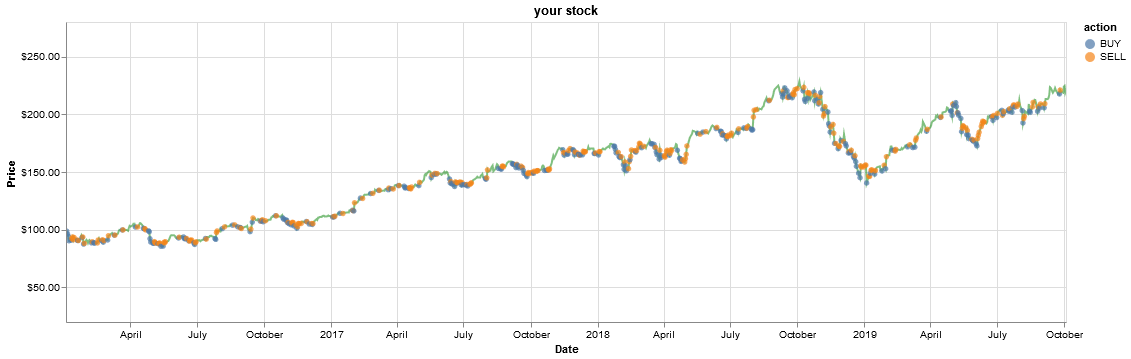

I1007 02:29:58.132617 15072 evaluate.py:111] model_w10v3_COST_20: +$382.66

2019-10-07 02:29:58 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$382.66



Earnings of :  ADBE  is:  382.6598358154297


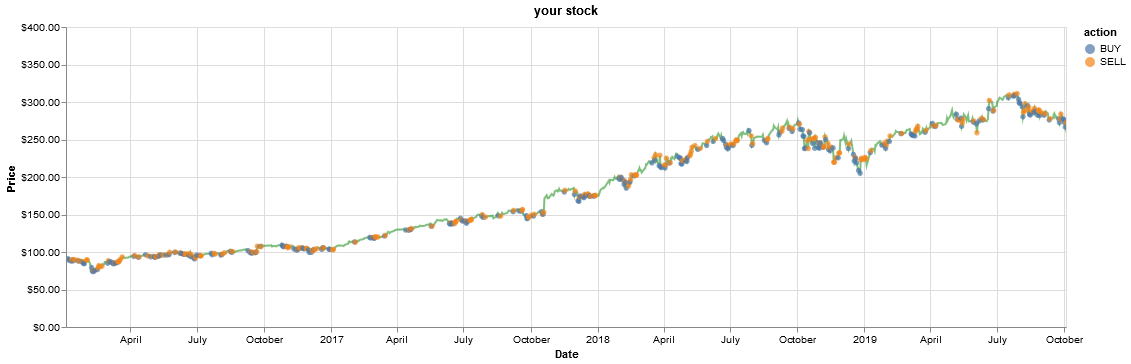

I1007 02:30:00.897301 15072 evaluate.py:111] model_w10v3_COST_20: -$16.14

2019-10-07 02:30:00 PC-Stefan root[3960] INFO model_w10v3_COST_20: -$16.14



Earnings of :  ANF  is:  -16.136780738830566


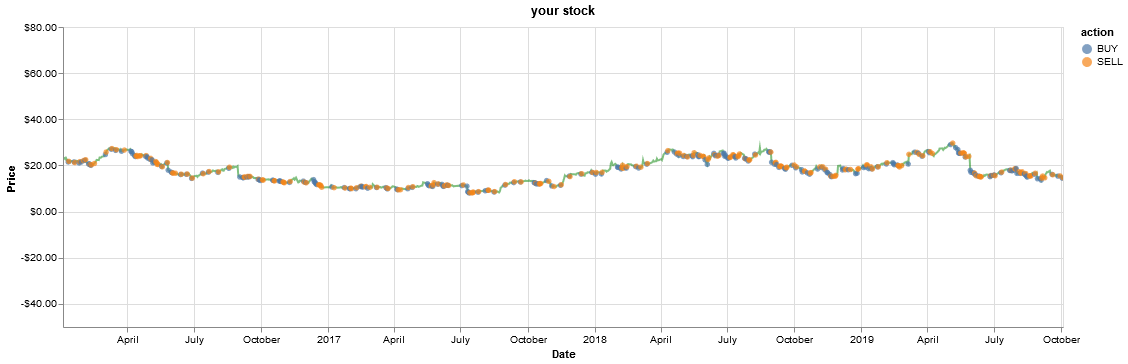

I1007 02:30:03.631863 15072 evaluate.py:111] model_w10v3_COST_20: +$133.27

2019-10-07 02:30:03 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$133.27



Earnings of :  COST  is:  133.2709197998047


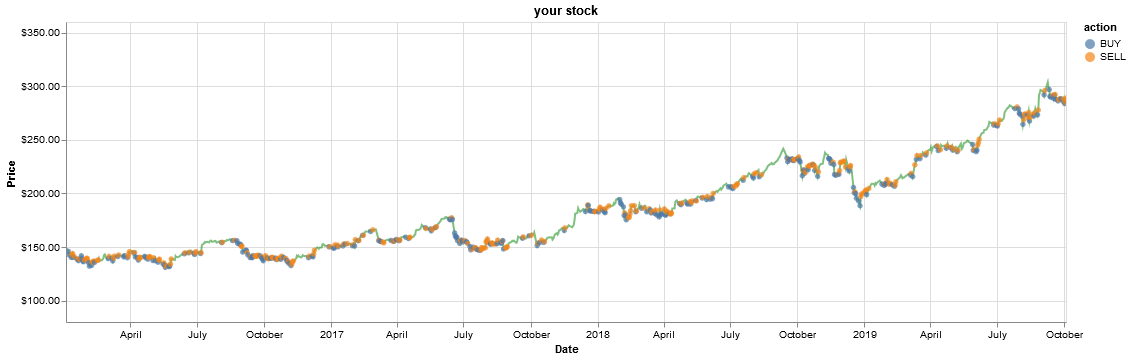

I1007 02:30:06.361633 15072 evaluate.py:111] model_w10v3_COST_20: -$1.96

2019-10-07 02:30:06 PC-Stefan root[3960] INFO model_w10v3_COST_20: -$1.96



Earnings of :  GOLD  is:  -1.9570517539978027


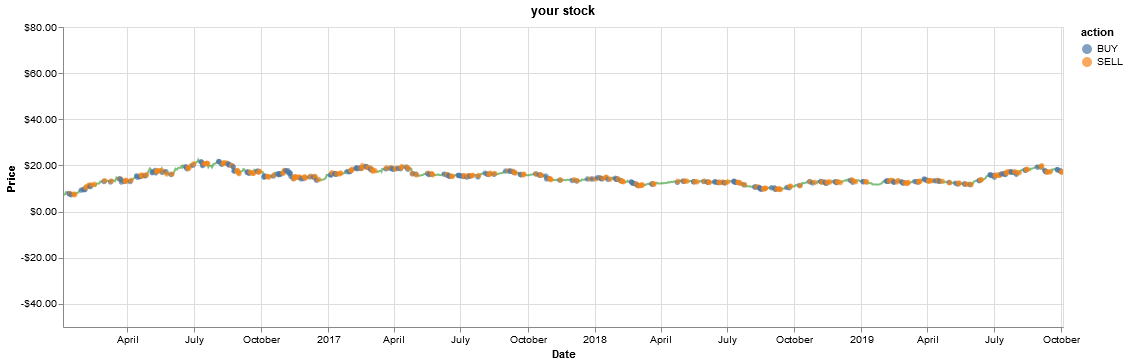

I1007 02:30:09.018061 15072 evaluate.py:111] model_w10v3_COST_20: +$146.53

2019-10-07 02:30:09 PC-Stefan root[3960] INFO model_w10v3_COST_20: +$146.53



Earnings of :  RCL  is:  146.5254898071289


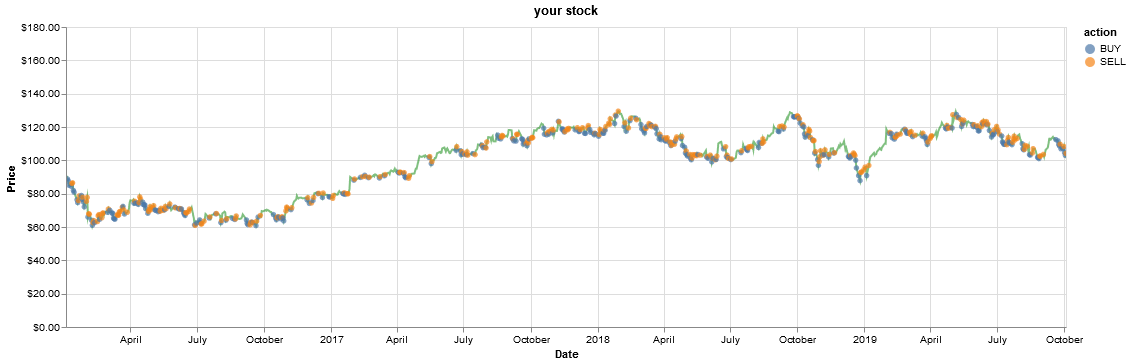

Sum of all earnings:  model_w10v3_COST_20  is:  735.8590865135193


In [8]:
# Test 1 model
    
#model_name = 'model_w15v2_40' model_Stefan_10
model_name = "model_w10v3_COST_20"

# Init Model
window_size = 10


# Initialize Agent
if df2_test_list is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)

sum = 0
# Loop over stocks
for column in df_test:
    #print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    initial_offset = df_test_list[1] - df_test_list[0]
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset);
    chart = visualize(dft, history)
    sum = sum+val_result
    print("Earnings of : ", column, " is: ", val_result)
    chart.display()
print("Sum of all earnings: ", model_name, " is: ", sum)


In [9]:
dft.head(200)

Symbols,AAPL,ADBE,ANF,COST,GOLD,actual,position,action
Date,,,,,,,,
2016-01-04,98.742249,91.970001,23.073023,147.152557,7.478310,90.324860,90.324860,HOLD
2016-01-05,96.267815,92.339996,23.216385,147.512253,7.381814,88.852280,90.324860,HOLD
2016-01-06,94.383888,91.019997,22.752563,146.147202,7.661649,87.720222,88.852280,BUY
2016-01-07,90.400467,89.110001,23.283852,142.799042,8.443253,85.069565,87.720222,BUY
2016-01-08,90.878479,87.849998,21.529758,140.299454,8.124820,84.471329,85.069565,BUY
2016-01-11,92.350006,89.379997,21.816490,142.706802,7.864287,86.146400,84.471329,BUY
2016-01-12,93.690300,89.820000,21.959852,143.942764,7.623052,86.532928,86.146400,SELL
2016-01-13,91.281494,88.300003,21.529758,140.308655,7.758143,81.949516,86.532928,SELL
2016-01-14,93.277916,89.800003,21.993586,141.286377,7.314269,80.900299,81.949516,BUY
